# Import Packages

In [1]:
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.table import Table

# Define Directories and Filenames
One needs to have the L0 file KP.20221112.26598.92.fits and the 2D file KP.20221112.26598.92_2D.fits in the data/ directory of the folder from which this notebook is running.  These files can be downloaded from Jump or shrek.caltech.edu.  Note that as of 11/23/2022, the 2D file will have the name KP.20221112.26598.92.fits and will need to be renamed KP.20221112.26598.92_2D.fits for the code below to work.  One can also modify the code below to work with other files or paths.

In [2]:
L0_data_dir = 'data/'
ObsID = 'KP.20221112.26598.92' # Commissioning Spectrum of 51 Pegasi
L0_file = L0_data_dir + ObsID + '.fits'
D2_file = L0_data_dir + ObsID + '_2D.fits' # 2D file (which needs to be renamed with '_2D' appended)

# Open File and Show Information
Note that there are exensions for:
  * Header keywords (PRIMARY)
  * Four quadrants of the green CCD (GREEN_AMP1, GREEN_AMP2, GREEN_AMP3, GREEN_AMP4)
  * Two halves of the red CCD (RED_AMP1, RED_AMP2)
  * Spectral time series for the Exposure Meter (EXPMETER_SCI, EXPMETER_SKY)
  * Telemetry (HDU needs to be named! It just has the index 9 here.  This was fixed in the L0 Assembler on 11/22/22.)

In [3]:
L0 = fits.open(L0_file)
L0.info()

Filename: data/KP.20221112.26598.92.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     301   ()      
  1  GREEN_AMP1    1 ImageHDU        13   (2144, 2140)   int32   
  2  GREEN_AMP2    1 ImageHDU        13   (2144, 2140)   int32   
  3  GREEN_AMP3    1 ImageHDU        13   (2144, 2140)   int32   
  4  GREEN_AMP4    1 ImageHDU        13   (2144, 2140)   int32   
  5  RED_AMP1      1 ImageHDU        13   (2144, 4180)   int32   
  6  RED_AMP2      1 ImageHDU        13   (2144, 4180)   int32   
  7  EXPMETER_SCI    1 BinTableHDU    855   156R x 423C   [23A, 23A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 

# Primary Extension (header keywords)
Here is a list of keywords.  Later data products (2D, L1, L2 add keywords to this list)

In [4]:
L0['PRIMARY'].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
FAVER   = '0       '           / Written by FITSAssemble version 1.3            
TIMESYS = 'UTC     '                                                            
CAMERAS =                    3 / Detectors in assembly request                  
GREEN   = 'YES     '           / Was this camera found?                         
RED     = 'YES     '           / Was this camera found?                         
CA_HK   = 'NO      '           / Was this camera found?                         
EXPMETER= 'YES     '           / Was this camera found?                         
DATE-MID= '2022-11-12T07:25:49.061' / Halfway point of the exposure, unweighted 
COMMENT --------------------

# Extract Keywords
Here we extra the name of the target star and the exposure time and assign them to variables.

In [5]:
starname = L0['PRIMARY'].header['TARGNAME']
Texp = L0['PRIMARY'].header['GRELAPS'] # actually, this is the green CCD exposure time
print('Star = ' + starname)
print('Exposure time = ' + str(Texp) + ' sec')

Star = 217014
Exposure time = 300.019 sec


# Green CCD
There are four quadrants in the green CCD with separate extensions. Let's plot of them.

<Figure size 432x288 with 0 Axes>

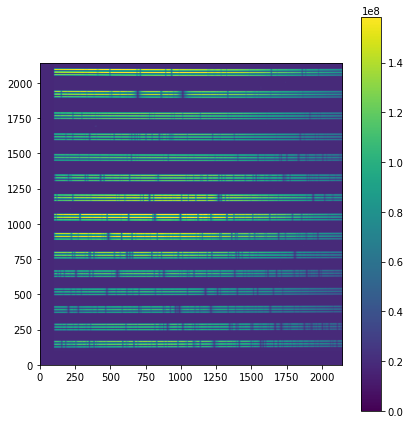

In [6]:
plt.figure(tight_layout=True)
plt.figure(figsize=(6, 6), tight_layout=True)
plt.imshow(L0['GREEN_AMP4'].data, cmap='viridis', origin='lower', vmin=0, vmax=np.percentile(L0['GREEN_AMP4'].data,99))
plt.colorbar()
plt.grid(False)
plt.show()

# Red CCD
There are two quadrantes for the Red CCD (when read out in 2-amplifier mode).  Let's plot one of them

<Figure size 432x288 with 0 Axes>

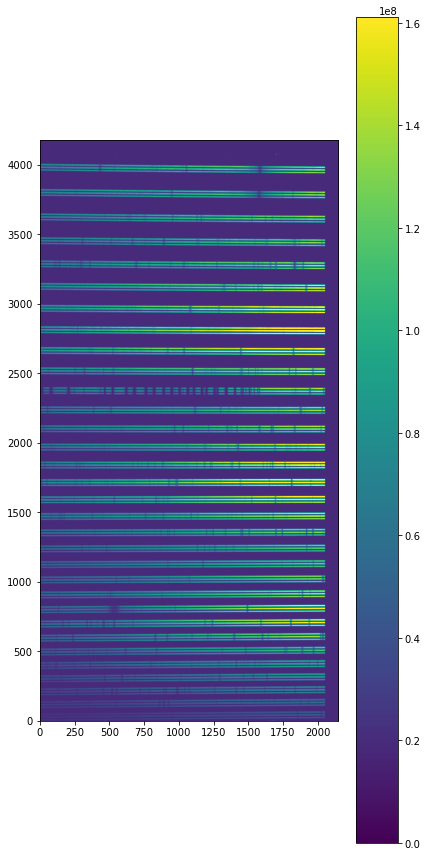

In [7]:
plt.figure(tight_layout=True)
plt.figure(figsize=(6, 12), tight_layout=True)
plt.imshow(L0['RED_AMP1'].data, cmap='viridis', origin='lower', vmin=0, vmax=np.percentile(L0['RED_AMP1'].data,99))
plt.colorbar()
plt.grid(False)
plt.show()

# 2D File
The 2D file is similar to L0 except that the image segments of the green and red CCDs have been assembled (prescan and overcal removed) and bias has been subtracted.  The header information has also been removed.

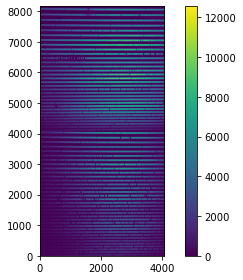

In [8]:
D2 = fits.open(D2_file)
plt.figure(tight_layout=True)
plt.imshow(np.rot90(D2['PRIMARY'].data), cmap='viridis', origin='lower', vmin=0, vmax=np.percentile(D2['PRIMARY'].data,99))
plt.colorbar()
plt.grid(False)
plt.show()

# Exposure Meter
Back in the L0 file, there are extensions for the EM SCI and EM SKY fibers.  The example below is for EM SCI, but EM SKY is similar.  Here we create a Pandas data frame with the spectral time series.  Each row is a spectrum for light collected between Date-Beg and Date-End.

In [9]:
df_SCI_EM = Table.read(L0_file, format='fits',hdu='EXPMETER_SCI').to_pandas()
df_SCI_EM

,Date-Beg,Date-End,872.5,867.2,862.0,856.9,851.9,847.0,842.2,837.4,...,447.8,447.5,447.2,446.8,446.5,446.2,445.8,445.5,445.2,444.9
0,b'2022-11-12T07:23:18.178',b'2022-11-12T07:23:19.316',7507.967104,7409.104433,7177.573912,7289.623486,6827.755809,7017.529870,6757.271241,6788.041106,...,618.376208,249.334198,196.814173,441.325255,376.063915,316.981177,564.989502,231.507711,393.132174,284.826221
1,b'2022-11-12T07:23:20.112',b'2022-11-12T07:23:21.250',18201.904825,17940.198046,17655.836891,17616.661388,17258.585515,16996.437100,16776.706667,16821.521289,...,1850.023282,1782.933123,1872.750894,1891.941497,1738.845973,1639.502467,1906.900367,1496.757227,1733.044240,1387.624673
2,b'2022-11-12T07:23:22.032',b'2022-11-12T07:23:23.169',27987.923441,27451.519165,27102.783798,26455.380750,26041.044319,25956.473646,25458.445480,25185.753055,...,1623.066890,1935.177865,1740.085938,1685.024563,1492.030618,1544.043768,1629.683142,1660.397259,1398.105916,1512.610647
3,b'2022-11-12T07:23:23.951',b'2022-11-12T07:23:25.094',27526.988735,27478.445630,26922.963360,26607.838051,26071.692794,25730.035359,25450.205814,25103.020826,...,1633.387710,1703.017965,1474.550850,1534.911182,1596.106164,1516.871472,1346.139818,1388.034454,1223.995201,1309.980786
4,b'2022-11-12T07:23:25.892',b'2022-11-12T07:23:27.030',35475.219898,35067.841707,34230.586140,33449.765562,32568.063011,32599.524393,31843.679208,31775.067456,...,1357.830378,1450.106361,1350.782929,1151.483150,1034.846600,1136.754370,1368.726852,1276.944385,982.556002,1039.052707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,b'2022-11-12T07:28:10.118',b'2022-11-12T07:28:11.247',37936.870914,37215.924969,36704.697617,35957.558510,34794.824710,34618.039017,33958.820419,33603.708612,...,1156.669438,934.243084,1151.000381,1104.020060,812.670885,1137.421221,925.799883,898.256754,942.629272,1022.445446
152,b'2022-11-12T07:28:12.044',b'2022-11-12T07:28:13.183',39086.931970,38573.093655,37645.614654,36774.482240,36471.943861,35314.276667,34797.417637,34304.256153,...,1022.862210,699.127243,933.910538,906.138154,818.432794,907.502081,651.448971,740.550695,913.368081,676.813109
153,b'2022-11-12T07:28:13.975',b'2022-11-12T07:28:15.118',27035.628301,26475.988109,26251.446151,25637.503285,24901.422706,24186.839574,24058.571706,23900.874626,...,870.608179,861.421921,763.215618,816.701449,916.272156,730.936048,858.768663,736.521211,738.401374,810.466651
154,b'2022-11-12T07:28:15.925',b'2022-11-12T07:28:17.062',24092.111511,23687.420712,23528.764756,23114.540543,22563.896973,21939.411676,21844.549906,21707.952115,...,839.214389,703.116257,861.901221,769.417366,855.844877,863.263834,676.338989,707.893803,655.240707,701.825653


# Convert Exposure Meter Data into Flux Measurements

In [10]:
# Gain of CCD in KPF Exposure Meter
EM_gain = 1.48424 # e-/ADU

# Define wavelength arrays and disperion at each wavelength (nm per pixel)
wav_SCI_str = df_SCI_EM.columns[2:] # string (center) wavelengths of each pixel
wav_SCI     = df_SCI_EM.columns[2:].astype(float) # float (center) wavelengths of each pixel
disp_SCI = wav_SCI*0+np.gradient(wav_SCI,1)*-1

# define normalized flux array (e- / nm / time)
df_SCI_EM_norm        = df_SCI_EM[wav_SCI_str] * EM_gain /disp_SCI

# define time arrays
date_beg = np.array(df_SCI_EM["Date-Beg"], dtype=np.datetime64)
date_end = np.array(df_SCI_EM["Date-End"], dtype=np.datetime64)
tdur_sec = (date_end-date_beg).astype(float)/1000. # array exposure durations in sec
time     = (date_beg-date_beg[0])/1000 # array of times since beginning in sec

# define indices for wavelength
ind_550m    = np.where((wav_SCI <  550))
ind_550_650 = np.where((wav_SCI >= 550) & (wav_SCI < 650))
ind_650_750 = np.where((wav_SCI >= 650) & (wav_SCI < 750))
ind_750p    = np.where((wav_SCI >= 750))

# define flux arrays
int_SCI_spec         = df_SCI_EM_norm[:5].sum(axis=0) / np.sum(tdur_sec[:5]) # flux vs. wavelength per sec (use first five samples)
int_SCI_flux         = df_SCI_EM.sum(axis=1)                         # flux (ADU) vs. time (per sample)
int_SCI_flux_550m    = df_SCI_EM[wav_SCI_str[np.where((wav_SCI <  550))]].sum(axis=1)
int_SCI_flux_550_650 = df_SCI_EM[wav_SCI_str[np.where((wav_SCI >= 550) & (wav_SCI < 650))]].sum(axis=1)
int_SCI_flux_650_750 = df_SCI_EM[wav_SCI_str[np.where((wav_SCI >= 650) & (wav_SCI < 750))]].sum(axis=1)
int_SCI_flux_750p    = df_SCI_EM[wav_SCI_str[np.where((wav_SCI >= 750))]].sum(axis=1)

/var/folders/kk/bxbvpk_j4q371d1wh64wykq00000gn/T/ipykernel_92988/1314969845.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  int_SCI_flux         = df_SCI_EM.sum(axis=1)                         # flux (ADU) vs. time (per sample)


# Plot EM SCI Spectrum

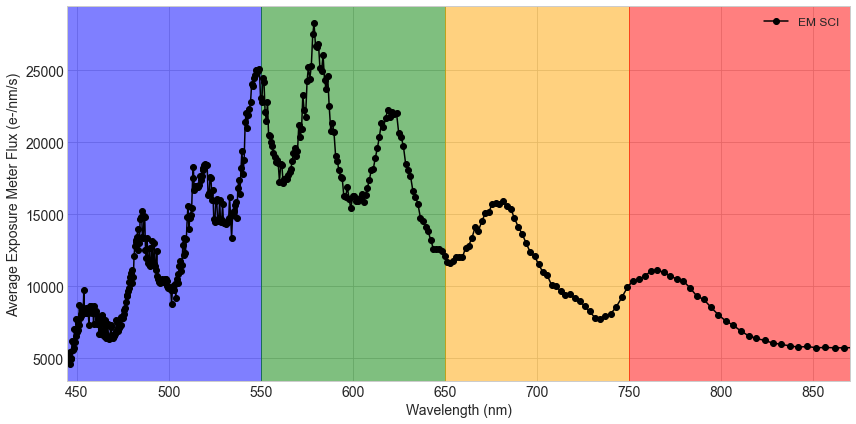

In [11]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12, 6), tight_layout=True)
plt.axvspan(440, 550, alpha=0.5, color='b') 
plt.axvspan(550, 650, alpha=0.5, color='g') 
plt.axvspan(650, 750, alpha=0.5, color='orange') 
plt.axvspan(750, 880, alpha=0.5, color='red') 
plt.plot(wav_SCI, int_SCI_spec, marker='o', color='k')
plt.xlabel("Wavelength (nm)", fontsize=14)
plt.ylabel("Average Exposure Meter Flux (e-/nm/s)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(445,870)
plt.legend(["EM SCI"], fontsize=12, loc='best') 
plt.show()
#plt.savefig('expmeter_flux_vs_wavelength.png',dpi=144)

# Plot EM SCI Time Series

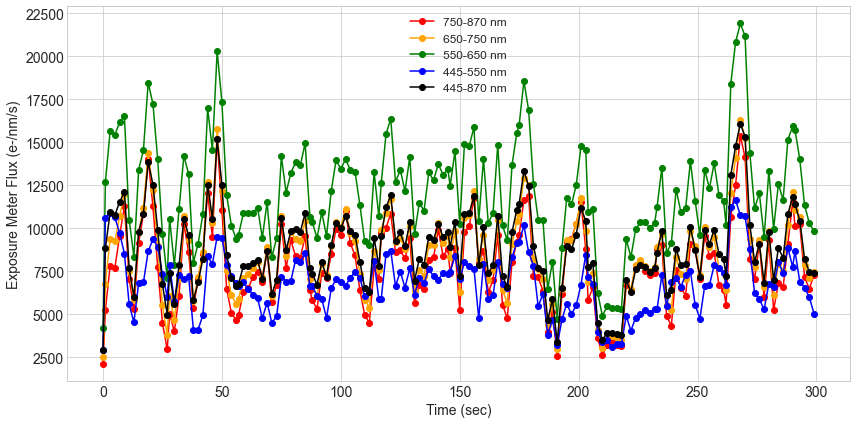

In [12]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12, 6), tight_layout=True)
plt.plot(time, int_SCI_flux_750p    / ((847+4.8/2)-750)           / tdur_sec, marker='o', color='r')
plt.plot(time, int_SCI_flux_650_750 / (750-650)                   / tdur_sec, marker='o', color='orange')
plt.plot(time, int_SCI_flux_550_650 / (650-550)                   / tdur_sec, marker='o', color='g')
plt.plot(time, int_SCI_flux_550m    / (550-(450.1-0.4/2))         / tdur_sec, marker='o', color='b')
plt.plot(time, int_SCI_flux         / ((847+4.8/2)-(450.1-0.4/2)) / tdur_sec, marker='o', color='k')
plt.xlabel("Time (sec)", fontsize=14)
plt.ylabel("Exposure Meter Flux (e-/nm/s)", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(["750-870 nm","650-750 nm","550-650 nm","445-550 nm","445-870 nm",], fontsize=12, loc='best') 
plt.show()

# Plot Fraction of Flux Time Series in Each Color Bin
This is a measure of the ADC performance.

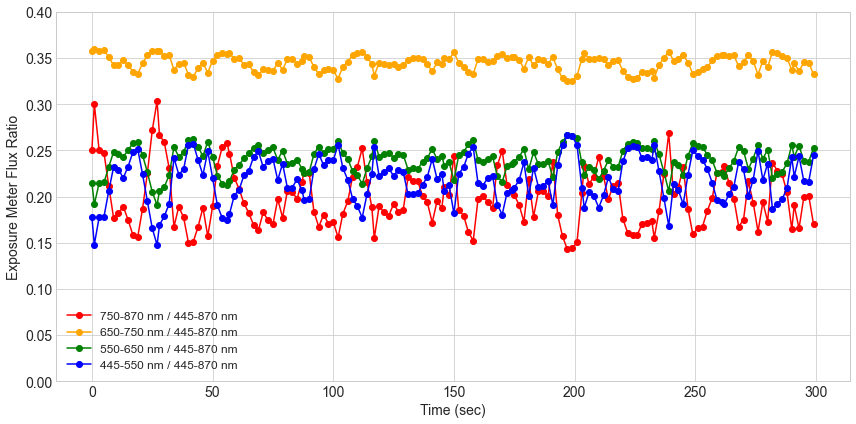

In [13]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12, 6), tight_layout=True)
plt.plot(time, (int_SCI_flux_550m    / int_SCI_flux ) , marker='o', color='r')
plt.plot(time, (int_SCI_flux_550_650 / int_SCI_flux ) , marker='o', color='orange')
plt.plot(time, (int_SCI_flux_650_750 / int_SCI_flux ) , marker='o', color='g')
plt.plot(time, (int_SCI_flux_750p    / int_SCI_flux ) , marker='o', color='b')
plt.xlabel("Time (sec)", fontsize=14)
plt.ylabel("Exposure Meter Flux Ratio", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0,0.4)
plt.legend(["750-870 nm / 445-870 nm","650-750 nm / 445-870 nm","550-650 nm / 445-870 nm","445-550 nm / 445-870 nm"], fontsize=12, loc='best') 
#plt.show()
plt.savefig('EM_flux_ratio_51peg.png')

# Telemetry
Each KPF L0 file contains telemetry on >100 sensors or state values with average, standard deviation, minimum, and maximum values listed.

In [14]:
# this HDU should be named 'TELEMETRY' instead of index=9 (or whatever is the last value)
# the bug was fixed in the L0 Assembly code on 11/22/22.  
# A future version up this notebook should update this.
df_telemetry = Table.read(L0_file, format='fits', hdu=9).to_pandas()  
num_columns = ['average', 'stddev', 'min', 'max']
for column in df_telemetry:
    df_telemetry[column] = df_telemetry[column].str.decode('utf-8')
    df_telemetry = df_telemetry.replace('-nan', 0)# replace nan with 0
    if column in num_columns:
        df_telemetry[column] = pd.to_numeric(df_telemetry[column], downcast="float")
    else:
        df_telemetry[column] = df_telemetry[column].astype(str)
df_telemetry.set_index("keyword", inplace=True)

In [15]:
df_telemetry.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116 entries, kpfmet.BENCH_BOTTOM_BETWEEN_CAMERAS to kpfpower.OUTLET_A1_Amps
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   average      116 non-null    float32
 1   stddev       116 non-null    float32
 2   min          116 non-null    float32
 3   max          116 non-null    float32
 4   units        116 non-null    object 
 5   description  116 non-null    object 
dtypes: float32(4), object(2)
memory usage: 4.5+ KB


Print the entire table of telemetry.

In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_telemetry)

,average,stddev,min,max,units,description
keyword,,,,,,
kpfmet.BENCH_BOTTOM_BETWEEN_CAMERAS,1.743070e+01,4.817150e-04,1.743000e+01,1.743200e+01,degC,Bench Bottom Between Cameras C2 c- double degC...
kpfmet.BENCH_BOTTOM_COLLIMATOR,1.803690e+01,5.135500e-04,1.803600e+01,1.803800e+01,degC,Bench Bottom Coll C3 c- double degC {%.3f}
kpfmet.BENCH_BOTTOM_DCUT,1.781270e+01,6.067910e-04,1.781200e+01,1.781400e+01,degC,Bench Bottom D-cut C4 c- double degC {%.3f}
kpfmet.BENCH_BOTTOM_ECHELLE,1.795330e+01,4.740290e-04,1.795200e+01,1.795400e+01,degC,Bench Bottom Echelle Cam B c- double degC {%.3f}
kpfmet.BENCH_TOP_BETWEEN_CAMERAS,1.733170e+01,4.920710e-04,1.733000e+01,1.733200e+01,degC,Bench Top Between Cameras D4 c- double degC {%...
kpfmet.BENCH_TOP_COLL,1.813210e+01,5.333490e-04,1.813100e+01,1.813300e+01,degC,Bench Top Coll D5 c- double degC {%.3f}
kpfmet.BENCH_TOP_DCUT,1.784160e+01,5.604510e-04,1.784100e+01,1.784300e+01,degC,Bench Top D-cut D3 c- double degC {%.3f}
kpfmet.BENCH_TOP_ECHELLE_CAM,1.789740e+01,4.959300e-04,1.789700e+01,1.789800e+01,degC,Bench Top Echelle Cam D1 c- double degC {%.3f}
kpfmet.CAL_BENCH,2.130000e+01,0.000000e+00,2.130000e+01,2.130000e+01,degC,Cal_Bench temperature c- double degC {%.1f}


Print the average and standard deviation of one keyword.

In [17]:
print('Red CCD Temperature = ', df_telemetry.at['kpfred.STA_CCD_T', 'average'], '+/-', df_telemetry.at['kpfred.STA_CCD_T', 'stddev'], df_telemetry.at['kpfred.STA_CCD_T', 'units'])

Red CCD Temperature =  -100.0 +/- 0.00134479 degC
